In [1]:
import json
import os
from prettytable import PrettyTable
from collections import defaultdict
import numpy as np

root_dir = "../src_server/src"

save_dir = "../src/t_test"
os.makedirs(save_dir, exist_ok=True)

headers = ['val_sdf_loss/dataloader_idx_0',
        'val_smoothness_diff/dataloader_idx_1',
        'val_reconstruction_loss'
        ]

import pandas as pd

table_headers = [
    'MSE_sdf',
    'smoothness_diff',
    'MSE_chi'
]

latex_table_headers = [
    r"$MSE_{Hv}$",
    r"Smooth",
    r"$MSE_{\chi}$"
]

metrics_smaller_is_better = [
    'MSE_sdf',
    'smoothness_diff',
    'MSE_chi'
]

metrics_larger_is_better = ['MI_tau']

first_strtg_meta = {
    "result_pathes_prefix": os.path.join(root_dir, "final_metrics_round"),
    "result_pathes_suffixes": ["_frst_strtg_AEs.json",
                            "_frst_strtg_MMD_VAEs.json",
                            "_frst_strtg_VAEs.json"
                            ],
    "reconstruction_result_pathes_prefix": os.path.join(root_dir, "final_metrics_round"),
    "reconstruction_results_pathes_suffixes": ["_frst_strtg_AEs_recon.json",
                                    "_frst_strtg_MMD_VAEs_recon.json",
                                    "_frst_strtg_VAEs_recon.json"
                                    ]}

second_strtg_meta = {
    # "reconstruction_results_pathes": ["_scnd_strtg_AEs_recon.json",
    #                                     "_scnd_strtg_MMD_VAEs_recon.json",
    #                                     "_scnd_strtg_VAEs_recon.json"
    #                                     ],
    "result_pathes_prefix": os.path.join(root_dir, "final_metrics_round"),
    "result_pathes_suffixes": ["_scnd_strtg_AEs.json",
                                "_scnd_strtg_MMD_VAEs.json",
                                "_scnd_strtg_VAEs.json"],
    "reconstruction_result_pathes_prefix": os.path.join(root_dir, "final_metrics_round"),
    "reconstruction_results_pathes_suffixes": ["_scnd_strtg_AEs_recon.json",
                                        "_scnd_strtg_MMD_VAEs_recon.json",
                                        "_scnd_strtg_VAEs_recon.json"
                                        ]}


model_name_inclusion = "_20smf"
# experiment_indeces = [1, 2, 3, 4, 5]
experiment_indeces = [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 20, 21, 22, 23, 24, 25, 26]

In [2]:
# Initialize dictionaries to store all metrics for each model
def extract_metrics(result_pathes_prefix,
                    result_pathes_suffixes,
                    reconstruction_result_pathes_prefix,
                    reconstruction_results_pathes_suffixes,
                    model_name_inclusion,
                    experiment_indeces,
                    strategy_name):
    
    recon_suffix = "_recon_dec"

    replace_in_name = {
        "frst": "st1",
        "scnd": "st2"
        }


    all_reconstruction_metrics = defaultdict(lambda: defaultdict(list))
    all_results_metrics = defaultdict(lambda: defaultdict(list))

    for experiment_index in experiment_indeces:
        reconstruction_results_pathes = [reconstruction_result_pathes_prefix + str(experiment_index) + suffix for suffix in reconstruction_results_pathes_suffixes]
        for path in reconstruction_results_pathes:
            if os.path.exists(path):
                with open(path, 'r') as file:
                    recon_results = json.load(file)
                    # Remove suffix in keys of recon_results
                    recon_results = {key.replace(recon_suffix, ''): value for key, value in recon_results.items()}
                    for model_name, metrics in recon_results.items():
                        if model_name_inclusion in model_name:
                            for metric_name, value in metrics.items():
                                used_model_name = model_name
                                for key, changer in replace_in_name.items():
                                    used_model_name = used_model_name.replace(key, changer)
                                used_model_name = used_model_name.replace(model_name_inclusion, "")
                            
                                
                                all_reconstruction_metrics[used_model_name][metric_name].append(value)

        result_pathes = [result_pathes_prefix + str(experiment_index) + suffix for suffix in result_pathes_suffixes]
        for path in result_pathes:
            if os.path.exists(path):
                with open(path, 'r') as file:
                    res = json.load(file)
                    for model_name, metrics in res.items():
                        if model_name_inclusion in model_name:
                            for metric_name, value in metrics.items():
                                used_model_name = model_name
                                for key, changer in replace_in_name.items():
                                    used_model_name = used_model_name.replace(key, changer)
                                used_model_name = used_model_name.replace(model_name_inclusion, "")
                                all_results_metrics[used_model_name][metric_name].append(value)


    return all_reconstruction_metrics, all_results_metrics

frst_strtg_recon_metrics, frst_strtg_results_metrics = extract_metrics(first_strtg_meta["result_pathes_prefix"],
                                                                      first_strtg_meta["result_pathes_suffixes"],
                                                                      first_strtg_meta["reconstruction_result_pathes_prefix"],
                                                                      first_strtg_meta["reconstruction_results_pathes_suffixes"],
                                                                      model_name_inclusion,
                                                                      experiment_indeces,
                                                                      "frst_strtg")

scnd_strtg_recon_metrics, scnd_strtg_results_metrics = extract_metrics(second_strtg_meta["result_pathes_prefix"],
                                                                      second_strtg_meta["result_pathes_suffixes"],
                                                                      second_strtg_meta["reconstruction_result_pathes_prefix"],
                                                                      second_strtg_meta["reconstruction_results_pathes_suffixes"],
                                                                      model_name_inclusion,
                                                                      experiment_indeces,
                                                                      "scnd_strtg")

all_reconstruction_metrics = {**frst_strtg_recon_metrics, **scnd_strtg_recon_metrics}
all_results_metrics = {**frst_strtg_results_metrics, **scnd_strtg_results_metrics}

combined_metrics = {**all_reconstruction_metrics, **all_results_metrics}

# Compute mean and std for each metric
reconstruction_results = {}
for model_name, metrics in all_reconstruction_metrics.items():
    reconstruction_results[model_name] = {metric_name: {'mean': np.mean(values), 'std': np.std(values)} for metric_name, values in metrics.items()}

results = {}
for model_name, metrics in all_results_metrics.items():
    results[model_name] = {metric_name: {'mean': np.mean(values), 'std': np.std(values)} for metric_name, values in metrics.items()}

for model_name, metrics in reconstruction_results.items():
    if model_name in results:
        combined_metrics = {**metrics, **results[model_name]}
    else:
        combined_metrics = metrics

    results[model_name] = combined_metrics



In [3]:
table = PrettyTable()
table.field_names = ["Model"] + table_headers

# Find best values for each metric
best_values = {}
for header in headers:
    values = [metrics[header]['mean'] if header in metrics else float('inf') for metrics in results.values()]
    if header in [headers[i] for i, h in enumerate(table_headers) if h in metrics_smaller_is_better]:
        best_values[header] = min(values)
    else:
        best_values[header] = max(values)

# Create lists to store data for pandas DataFrame
df_data = []

for model_name, metrics in results.items():
    # print(model_name)
    row = [model_name]
    row_data = {'Model': model_name}
    
    for i, header in enumerate(headers):
        mean_value = metrics.get(header, {}).get('mean', "N/A")
        std_value = metrics.get(header, {}).get('std', "N/A")
        if mean_value != "N/A" and std_value != "N/A":
            # Add * if this is the best value
            is_best = abs(mean_value - best_values[header]) < 1e-10
            formatted_value = f"\033[91m{mean_value:.3g} ± {std_value:.3g}\033[0m" if is_best else f"{mean_value:.3g} ± {std_value:.3g}"
            row.append(formatted_value)
            # Store raw value in row_data for DataFrame
            row_data[table_headers[i]] = (mean_value, std_value)
        else:
            row.append("N/A")
            row_data[table_headers[i]] = None
            
    table.add_row(row)
    df_data.append(row_data)

print(table)
    

+---------------------+---------------------+--------------------+---------------------+
|        Model        |       MSE_sdf       |  smoothness_diff   |       MSE_chi       |
+---------------------+---------------------+--------------------+---------------------+
|        st1_AE       |  0.0014 ± 0.000268  | 0.0165 ± 0.000658  |  0.000229 ± 3.5e-05 |
|    st1_AE_DeepSDF   | 0.000346 ± 1.81e-05 | 0.00586 ± 9.95e-05 |   0.0002 ± 3.4e-05  |
|     st1_MMD_VAE     |  0.00134 ± 0.000233 | 0.0161 ± 0.000667  | 0.000212 ± 3.08e-05 |
| st1_MMD_VAE_DeepSDF | 0.000368 ± 1.95e-05 |  0.006 ± 0.000102  | 0.000228 ± 3.52e-05 |
|       st1_VAE       |  0.00128 ± 0.000201 | 0.0163 ± 0.000574  |   0.000117 ± 2e-05  |
|   st1_VAE_DeepSDF   | 0.000277 ± 1.07e-05 | 0.00575 ± 7.11e-05 | 0.000202 ± 2.82e-05 |
|        st2_AE       |  0.00155 ± 0.000257 |  0.0175 ± 0.00044  | 0.000232 ± 5.27e-05 |
|    st2_AE_DeepSDF   | 0.000796 ± 0.000101 | 0.0084 ± 0.000286  | 0.000226 ± 5.04e-05 |
|     st2_MMD_VAE    

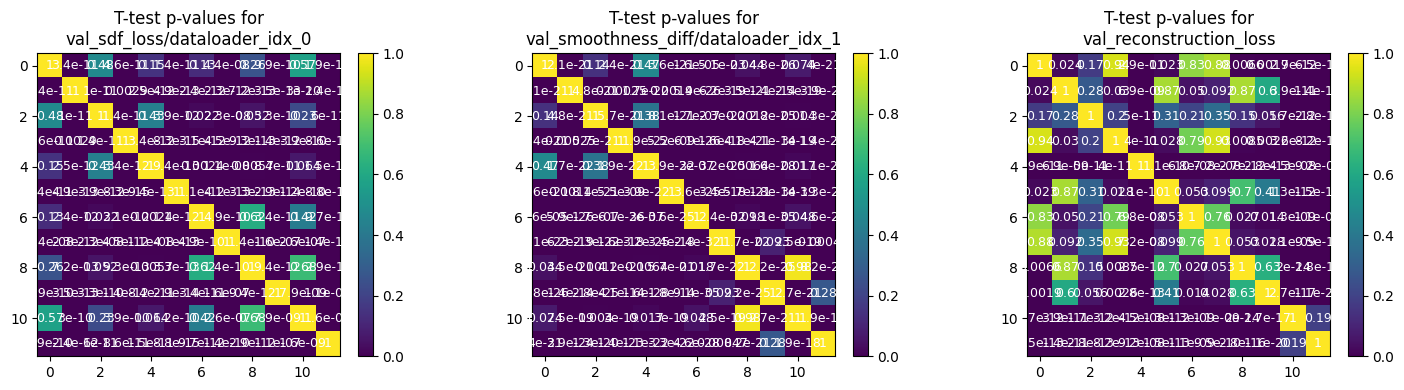

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ttest_ind

# Combine raw metrics from both reconstruction and results dictionaries into one dictionary.
# This "combined_raw_metrics" will have, for each model, for each metric, an array of values across experiments.
combined_raw_metrics = {}
# Get all model names from both dictionaries
all_models = set(list(all_reconstruction_metrics.keys()) + list(all_results_metrics.keys()))
for model in all_models:
    combined_raw_metrics[model] = {}
    # Get metric keys from reconstruction and results (if available)
    recon_metrics = all_reconstruction_metrics.get(model, {})
    res_metrics = all_results_metrics.get(model, {})
    all_metric_keys = set(list(recon_metrics.keys()) + list(res_metrics.keys()))
    for metric_key in all_metric_keys:
        values = []
        if metric_key in recon_metrics:
            values.extend(recon_metrics[metric_key])
        if metric_key in res_metrics:
            values.extend(res_metrics[metric_key])
        # Store as a numpy array for easier processing
        combined_raw_metrics[model][metric_key] = np.array(values)

# Define which metrics to perform t-tests on.
# We use the same "headers" as in the table generation.
metrics_to_test = headers  # e.g., ['val_sdf_loss/dataloader_idx_0', 'val_smoothness_diff/dataloader_idx_1', 'val_reconstruction_loss']

# Get a sorted list of model names to ensure consistent ordering.
model_names = sorted(list(combined_raw_metrics.keys()))

# Setup one subplot per metric
num_metrics = len(metrics_to_test)
fig, axes = plt.subplots(1, num_metrics, figsize=(5 * num_metrics, 4))
if num_metrics == 1:
    axes = [axes]  # Ensure axes is iterable

# For each metric, perform pairwise t-tests between models and plot the p-values as a heatmap.
for ax, metric in zip(axes, metrics_to_test):
    # Initialize a matrix to store the p-values.
    pvals = np.full((len(model_names), len(model_names)), np.nan)
    for i, model_i in enumerate(model_names):
        for j, model_j in enumerate(model_names):
            # Only perform the t-test if both models have values for this metric.
            if metric in combined_raw_metrics[model_i] and metric in combined_raw_metrics[model_j]:
                data_i = combined_raw_metrics[model_i][metric]
                data_j = combined_raw_metrics[model_j][metric]
                # Ensure there is enough data for a t-test.
                if len(data_i) > 1 and len(data_j) > 1:
                    # Use Welch's t-test (unequal variances)
                    stat, p_value = ttest_ind(data_i, data_j, equal_var=False)
                    pvals[i, j] = p_value

    # Plot the matrix as a heatmap.
    cax = ax.imshow(pvals, cmap='viridis', interpolation='nearest')
    ax.set_title(f"T-test p-values for\n{metric}")
    # ax.set_xticks(np.arange(len(model_names)))
    # ax.set_yticks(np.arange(len(model_names)))
    # ax.set_xticklabels(model_names, rotation=45, ha='right')
    # ax.set_yticklabels(model_names)
    fig.colorbar(cax, ax=ax, fraction=0.046, pad=0.04)

    # Annotate each cell with the p-value or "N/A" if not available.
    for i in range(len(model_names)):
        for j in range(len(model_names)):
            p_val = pvals[i, j]
            if not np.isnan(p_val):
                ax.text(j, i, f"{p_val:.2g}", ha="center", va="center", color="w", fontsize=9)
            else:
                ax.text(j, i, "N/A", ha="center", va="center", color="w", fontsize=9)

plt.tight_layout()
plt.show()


In [5]:
def p_values_matrixes(combined_raw_metrics, model_names, metrics_to_test):
    p_values_matrixes = {}
    for metric in metrics_to_test:
        # Initialize a matrix to store the p-values.
        pvals = np.full((len(model_names), len(model_names)), np.nan)
        for i, model_i in enumerate(model_names):
            for j, model_j in enumerate(model_names):
                # Only perform the t-test if both models have values for this metric.
                if metric in combined_raw_metrics[model_i] and metric in combined_raw_metrics[model_j]:
                    data_i = combined_raw_metrics[model_i][metric]
                    data_j = combined_raw_metrics[model_j][metric]
                    # Ensure there is enough data for a t-test.
                    if len(data_i) > 1 and len(data_j) > 1:
                        # Use Welch's t-test (unequal variances)
                        stat, p_value = ttest_ind(data_i, data_j, equal_var=False)
                        pvals[i, j] = p_value
        p_values_matrixes[metric] = pvals

    return p_values_matrixes

p_values_matrixes = p_values_matrixes(combined_raw_metrics, model_names, metrics_to_test)

In [6]:

def boxplot_metrics(combined_raw_metrics, model_names,
                    metrics_to_test, latex_table_headers,
                    exclusion_list=None, inclusion_list=None,
                    p_args=None,
                    figs_y_scale=5,
                    filename=None):
    
    fig_box, axes_box = plt.subplots(len(metrics_to_test), 1, figsize=(10, figs_y_scale * len(metrics_to_test)))
    if len(metrics_to_test) == 1:
        axes_box = [axes_box]  # Ensure axes_box is iterable

    for i, (ax, metric) in enumerate(zip(axes_box, metrics_to_test)):
        # Gather boxplot data: one series per model for the current metric
        boxplot_data = []
        filtered_model_names = []

        for model in model_names:
            if exclusion_list:
                excluded = False
                for exclusion in exclusion_list:
                    if exclusion in model:
                        excluded = True
                        break
                if excluded:
                    continue
            if inclusion_list:
                included = False
                for inclusion in inclusion_list:
                    if inclusion in model:
                        included = True
                        break
                if not included:
                    continue

            filtered_model_names.append(model)
            # Safely retrieve the metric values; default to an empty list if missing.
            values = combined_raw_metrics.get(model, {}).get(metric, [])
            boxplot_data.append(values)
        
        # Create a horizontal boxplot for the current metric by setting vert=False
        bp = ax.boxplot(boxplot_data, patch_artist=True, vert=False)

        if p_args:
            p_values = []
            wrt_model_idx = model_names.index(p_args["wrt_models_from_metric"][metric])
            for filtered_model_name in filtered_model_names:
                model_idx = model_names.index(filtered_model_name)
                p_value = p_values_matrixes[metric][model_idx, wrt_model_idx]
                p_values.append(p_value)
                # print(f"{filtered_model_name} vs {p_args['wrt_model']}: p = {p_value:.2g}")
            
        ax.set_title(f"{latex_table_headers[i]}")
        # Since the boxplot is rotated, the metric is now on the x-axis and models on the y-axis.
        ax.set_xlabel(latex_table_headers[i])
        ax.set_ylabel("Strategy_Model")
        ax.set_yticklabels(filtered_model_names)
        if p_values:
            # Create a secondary y-axis on the right to display p-values
            ax2 = ax.twinx()
            # Ensure the secondary axis has the same y-limits as the primary axis
            ax2.set_ylim(ax.get_ylim())
            # Set y-ticks on the secondary axis to match those of the primary axis
            ax2.set_yticks(ax.get_yticks())
            # Assign formatted p-value labels to the secondary y-axis ticks
            ax2.set_yticklabels([f"{pv:.2g}" for pv in p_values])
            # Optionally, adjust tick parameters for clarity (e.g., remove tick marks)
            # ax2.tick_params(axis="y", length=0)
            ax2.set_ylabel(f'p-value wrt \n{p_args["wrt_models_from_metric"][metric]}')

    plt.tight_layout()
    if filename:
        plt.savefig(filename)
    plt.show()


In [7]:
def prepare_latex_table(metric: str, ref_model: str, combined_raw_metrics: dict, model_order: list = None,
                        metric_latex_format: str = None) -> str:
    """
    Prepare a LaTeX table for a specified metric, including rows for mean, standard deviation, and p-values.
    
    The table is structured into two major strategy groups, each further split into two conditions 
    (with or without DeepSDF) and, within each, three model variants: AE, MMD-VAE, and VAE.
    P-values are computed via a two-sample t-test comparing each method’s results against the reference model.
    
    Parameters
    ----------
    metric : str
        The metric to build the table for.
    ref_model : str
        The model used as a reference for computing p-values.
    combined_raw_metrics : dict
        Nested dictionary with the structure:
          {model_name: {metric: [values], ...}, ...}
    model_order : list, optional
        List specifying the desired column order (model names) for the table.
        If None, a default ordering is used matching the table layout:
          First strategy:  [st1_AE, st1_MMD-VAE, st1_VAE,
                            st1_AE_noDS, st1_MMD-VAE_noDS, st1_VAE_noDS]
          Second strategy: [st2_AE_DS, st2_MMD-VAE_DS, st2_VAE_DS,
                            st2_AE, st2_MMD-VAE, st2_VAE]
    
    Returns
    -------
    str
        A string containing the formatted LaTeX table.
    """
    import numpy as np
    from scipy.stats import ttest_ind

    if model_order is None:
        # Default ordering: four groups (2 strategies × 2 conditions), 3 models each.
        model_order = [
            "st1_AE",
            "st1_MMD_VAE",
            "st1_VAE",
            "st1_AE_DeepSDF",
            "st1_MMD_VAE_DeepSDF",
            "st1_VAE_DeepSDF",
            "st2_AE",
            "st2_MMD_VAE",
            "st2_VAE",
            "st2_AE_DeepSDF",
            "st2_MMD_VAE_DeepSDF",
            "st2_VAE_DeepSDF",
        ]
    
    means = []
    stds = []
    p_values = []
    
    # Retrieve the reference model's metric values.
    ref_vals = np.array(combined_raw_metrics.get(ref_model, {}).get(metric, []))
    if ref_vals.size == 0:
        raise ValueError(f"No values found for reference model '{ref_model}' and metric '{metric}'.")
    
    for model in model_order:
        vals = np.array(combined_raw_metrics.get(model, {}).get(metric, []))
        if vals.size > 0:
            means.append(np.mean(vals))
            stds.append(np.std(vals))
            if model == ref_model:
                p_values.append("--")
            else:
                # Compute two-sample t-test assuming unequal variances.
                _, p_val = ttest_ind(vals, ref_vals, equal_var=False)
                p_values.append(f"{p_val:.2g}")
        else:
            means.append("--")
            stds.append("--")
            p_values.append("--")
    
    # Build LaTeX table string.
    lines = []
    lines = []  # Build Markdown table lines.
    # Define header row: first cell empty then one label per model column.
    
    header = [""] + ["AE", "MMD-VAE", "VAE", "AE", "MMD-VAE", "VAE", "AE", "MMD-VAE", "VAE", "AE", "MMD-VAE", "VAE"]
    # header = [""] + model_order
    lines.append("| " + " | ".join(header) + " |")
    lines.append("|" + "|".join(["---"] * len(header)) + "|")
    
    str_header = ["Strategy"] + ["st1" if "st1" in method else "st2" for method in model_order]
    lines.append("| " + " | ".join(str_header) + " |")
    str_header = ["Decoder"] + ["DeepSDF" if "DeepSDF" in method else "Symm." for method in model_order]
    lines.append("| " + " | ".join(str_header) + " |")
    
    # Mean row.
    mean_row = ["mean"] + [f"{m:.3g}" if isinstance(m, float) else m for m in means]
    lines.append("| " + " | ".join(mean_row) + " |")
    
    # Standard deviation row.
    std_row = ["std"] + [f"{s:.3g}" if isinstance(s, float) else s for s in stds]
    lines.append("| " + " | ".join(std_row) + " |")
    
    # P-value row.
    pval_row = ["p-value"] + p_values
    lines.append("| " + " | ".join(pval_row) + " |")
    
    # Add a caption below the table.
    lines.append(f"\n*Metric: {metric_latex_format} (p-values computed relative to {ref_model})*")
    
    return "\n".join(lines)

metric_for_comparison = "val_sdf_loss/dataloader_idx_0"
metric_latex_format = latex_table_headers[headers.index(metric_for_comparison)]
latex_table = prepare_latex_table("val_sdf_loss/dataloader_idx_0", "st1_VAE_DeepSDF", combined_raw_metrics, None, metric_latex_format)
print(latex_table)


|  | AE | MMD-VAE | VAE | AE | MMD-VAE | VAE | AE | MMD-VAE | VAE | AE | MMD-VAE | VAE |
|---|---|---|---|---|---|---|---|---|---|---|---|---|
| Strategy | st1 | st1 | st1 | st1 | st1 | st1 | st2 | st2 | st2 | st2 | st2 | st2 |
| Decoder | Symm. | Symm. | Symm. | DeepSDF | DeepSDF | DeepSDF | Symm. | Symm. | Symm. | DeepSDF | DeepSDF | DeepSDF |
| mean | 0.0014 | 0.00134 | 0.00128 | 0.000346 | 0.000368 | 0.000277 | 0.00155 | 0.0015 | 0.00146 | 0.000796 | 0.00059 | 0.000475 |
| std | 0.000268 | 0.000233 | 0.000201 | 1.81e-05 | 1.95e-05 | 1.07e-05 | 0.000257 | 0.00023 | 0.000327 | 0.000101 | 5.42e-05 | 3.51e-05 |
| p-value | 1.4e-11 | 3.9e-12 | 9.4e-13 | 4.9e-13 | 8.3e-15 | -- | 1.1e-12 | 3.3e-13 | 1.2e-10 | 4.1e-13 | 2.9e-14 | 8.8e-15 |

*Metric: $MSE_{Hv}$ (p-values computed relative to st1_VAE_DeepSDF)*


In [8]:
def prepare_latex_table_strategy_comparison(metric: str, ref_model: str, combined_raw_metrics: dict, model_order: list = None,
                        metric_latex_format: str = None) -> str:
    """
    Prepare a LaTeX table for a specified metric, including rows for mean, standard deviation, and p-values.
    
    The table is structured into two major strategy groups, each further split into two conditions 
    (with or without DeepSDF) and, within each, three model variants: AE, MMD-VAE, and VAE.
    P-values are computed via a two-sample t-test comparing each method’s results against the reference model.
    
    Parameters
    ----------
    metric : str
        The metric to build the table for.
    ref_model : str
        The model used as a reference for computing p-values.
    combined_raw_metrics : dict
        Nested dictionary with the structure:
          {model_name: {metric: [values], ...}, ...}
    model_order : list, optional
        List specifying the desired column order (model names) for the table.
        If None, a default ordering is used matching the table layout:
          First strategy:  [st1_AE, st1_MMD-VAE, st1_VAE,
                            st1_AE_noDS, st1_MMD-VAE_noDS, st1_VAE_noDS]
          Second strategy: [st2_AE_DS, st2_MMD-VAE_DS, st2_VAE_DS,
                            st2_AE, st2_MMD-VAE, st2_VAE]
    
    Returns
    -------
    str
        A string containing the formatted LaTeX table.
    """
    import numpy as np
    from scipy.stats import ttest_ind

    if model_order is None:
        # Default ordering: four groups (2 strategies × 2 conditions), 3 models each.
        # model_order = [
        #     "st1_AE",
        #     "st1_MMD_VAE",
        #     "st1_VAE",
        #     "st1_AE_DeepSDF",
        #     "st1_MMD_VAE_DeepSDF",
        #     "st1_VAE_DeepSDF",
        #     "st2_AE",
        #     "st2_MMD_VAE",
        #     "st2_VAE",
        #     "st2_AE_DeepSDF",
        #     "st2_MMD_VAE_DeepSDF",
        #     "st2_VAE_DeepSDF",
        # ]

        model_order = [
            "AE",
            "MMD_VAE",
            "VAE",
            "AE_DeepSDF",
            "MMD_VAE_DeepSDF",
            "VAE_DeepSDF",
        ]
    
    st1_means = []
    st2_means = []
    st1_stds = []
    st2_stds = []
    p_values = []
    
    # Retrieve the reference model's metric values.
    ref_vals = np.array(combined_raw_metrics.get(ref_model, {}).get(metric, []))
    if ref_vals.size == 0:
        raise ValueError(f"No values found for reference model '{ref_model}' and metric '{metric}'.")
    
    for model in model_order:
        st1_model = f"st1_{model}"
        st2_model = f"st2_{model}"
        st1_vals = np.array(combined_raw_metrics.get(st1_model, {}).get(metric, []))
        st2_vals = np.array(combined_raw_metrics.get(st2_model, {}).get(metric, []))
        if st1_vals.size > 0:
            st1_means.append(np.mean(st1_vals))
            st1_stds.append(np.std(st1_vals))
            st2_means.append(np.mean(st2_vals))
            st2_stds.append(np.std(st2_vals))

            # Compute two-sample t-test assuming unequal variances.
            _, p_val = ttest_ind(st1_vals, st2_vals, equal_var=False)
            p_values.append(f"{p_val:.2g}")
        else:
            st1_means.append("--")
            st1_stds.append("--")
            st2_means.append("--")
            st2_stds.append("--")
            p_values.append("--")
    
    # Build LaTeX table string.
    lines = []
    lines = []  # Build Markdown table lines.
    # Define header row: first cell empty then one label per model column.
    
    header = [""] + ["AE", "MMD-VAE", "VAE", "AE-DeepSDF", "MMD-VAE-DeepSDF", "VAE-DeepSDF"]
    # header = [""] + model_order
    lines.append("| " + " | ".join(header) + " |")
    lines.append("|" + "|".join(["---"] * len(header)) + "|")
    
    # str_header = ["Strategy"] + ["st1" if "st1" in method else "st2" for method in model_order]
    # lines.append("| " + " | ".join(str_header) + " |")
    # str_header = ["Decoder"] + ["DeepSDF" if "DeepSDF" in method else "Symm." for method in model_order]
    # lines.append("| " + " | ".join(str_header) + " |")
    
    # Mean row.
    st1_mean_row = ["Strategy 1 (mean)"] + [f"{m:.3g}" if isinstance(m, float) else m for m in st1_means]
    lines.append("| " + " | ".join(st1_mean_row) + " |")
    
    st2_mean_row = ["Strategy 2 (mean)"] + [f"{m:.3g}" if isinstance(m, float) else m for m in st2_means]
    lines.append("| " + " | ".join(st2_mean_row) + " |")
    
    # P-value row.
    pval_row = ["p-value"] + p_values
    lines.append("| " + " | ".join(pval_row) + " |")
    
    # Add a caption below the table.
    lines.append(f"\n*Metric: {metric_latex_format} (p-values computed relative to {ref_model})*")

    markdown_table = "\n".join(lines)

    # Build LaTeX table
    lines = []
    lines.append("\\renewcommand{\\arraystretch}{1.2} % Default value: 1")
    lines.append("\\begin{table}[ht]")
    lines.append(f"\\caption{{Comparison of training strategies for {metric_latex_format}}}")
    lines.append("\\centering")
    lines.append("\\begin{tabular}{|l|c|c|c|}")
    lines.append("\\hline")
    lines.append(" & ".join(["Model", "Strategy 1 (mean)", "Strategy 2 (mean)", "p-value"]) + " \\\ \hline")
    for i in range(len(header) - 1):
        model_name = header[i + 1]
        st1_val = f"{st1_means[i]:.3g}" if isinstance(st1_means[i], float) else st1_means[i]
        st2_val = f"{st2_means[i]:.3g}" if isinstance(st2_means[i], float) else st2_means[i]
        p_val = p_values[i]
        lines.append(" & ".join([model_name, st1_val, st2_val, p_val]) + " \\\ ")
        if model_name == "VAE":
            lines.append("\\hline")
    lines.append("\\hline")
    lines.append("\\end{tabular}")
    lines.append("\\label{tab:strategy_comparison}")
    lines.append("\\end{table}")

    latex_table = "\n".join(lines)
    
    return markdown_table, latex_table

metric_for_comparison = "val_sdf_loss/dataloader_idx_0"
metric_latex_format = latex_table_headers[headers.index(metric_for_comparison)]
markdown_table, latex_table = prepare_latex_table_strategy_comparison("val_sdf_loss/dataloader_idx_0", "st1_VAE_DeepSDF", combined_raw_metrics, None, metric_latex_format)
print(latex_table)


\renewcommand{\arraystretch}{1.2} % Default value: 1
\begin{table}[ht]
\caption{Comparison of training strategies for $MSE_{Hv}$}
\centering
\begin{tabular}{|l|c|c|c|}
\hline
Model & Strategy 1 (mean) & Strategy 2 (mean) & p-value \\ \hline
AE & 0.0014 & 0.00155 & 0.13 \\ 
MMD-VAE & 0.00134 & 0.0015 & 0.052 \\ 
VAE & 0.00128 & 0.00146 & 0.064 \\ 
\hline
AE-DeepSDF & 0.000346 & 0.000796 & 2.3e-12 \\ 
MMD-VAE-DeepSDF & 0.000368 & 0.00059 & 1.4e-12 \\ 
VAE-DeepSDF & 0.000277 & 0.000475 & 8.8e-15 \\ 
\hline
\end{tabular}
\label{tab:strategy_comparison}
\end{table}


<>:132: SyntaxWarning: invalid escape sequence '\ '
<>:138: SyntaxWarning: invalid escape sequence '\ '
<>:132: SyntaxWarning: invalid escape sequence '\ '
<>:138: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_65086/3026993641.py:132: SyntaxWarning: invalid escape sequence '\ '
  lines.append(" & ".join(["Model", "Strategy 1 (mean)", "Strategy 2 (mean)", "p-value"]) + " \\\ \hline")
/tmp/ipykernel_65086/3026993641.py:138: SyntaxWarning: invalid escape sequence '\ '
  lines.append(" & ".join([model_name, st1_val, st2_val, p_val]) + " \\\ ")


In [9]:
def prepare_latex_table_decoder_comparison(metric: str, ref_model: str, combined_raw_metrics: dict, model_order: list = None,
                        metric_latex_format: str = None) -> str:
    """
    Prepare a LaTeX table for a specified metric, including rows for mean, standard deviation, and p-values.
    
    The table is structured into two major strategy groups, each further split into two conditions 
    (with or without DeepSDF) and, within each, three model variants: AE, MMD-VAE, and VAE.
    P-values are computed via a two-sample t-test comparing each method’s results against the reference model.
    
    Parameters
    ----------
    metric : str
        The metric to build the table for.
    ref_model : str
        The model used as a reference for computing p-values.
    combined_raw_metrics : dict
        Nested dictionary with the structure:
          {model_name: {metric: [values], ...}, ...}
    model_order : list, optional
        List specifying the desired column order (model names) for the table.
        If None, a default ordering is used matching the table layout:
          First strategy:  [st1_AE, st1_MMD-VAE, st1_VAE,
                            st1_AE_noDS, st1_MMD-VAE_noDS, st1_VAE_noDS]
          Second strategy: [st2_AE_DS, st2_MMD-VAE_DS, st2_VAE_DS,
                            st2_AE, st2_MMD-VAE, st2_VAE]
    
    Returns
    -------
    str
        A string containing the formatted LaTeX table.
    """
    import numpy as np
    from scipy.stats import ttest_ind

    if model_order is None:
        # Default ordering: four groups (2 strategies × 2 conditions), 3 models each.
        # model_order = [
        #     "st1_AE",
        #     "st1_MMD_VAE",
        #     "st1_VAE",
        #     "st1_AE_DeepSDF",
        #     "st1_MMD_VAE_DeepSDF",
        #     "st1_VAE_DeepSDF",
        #     "st2_AE",
        #     "st2_MMD_VAE",
        #     "st2_VAE",
        #     "st2_AE_DeepSDF",
        #     "st2_MMD_VAE_DeepSDF",
        #     "st2_VAE_DeepSDF",
        # ]

        model_order = [
            "st1_AE",
            "st1_MMD_VAE",
            "st1_VAE",
            "st2_AE",
            "st2_MMD_VAE",
            "st2_VAE"
        ]
    
    ds_means = []
    sym_means = []
    ds_stds = []
    sym_stds = []
    p_values = []
    
    # Retrieve the reference model's metric values.
    ref_vals = np.array(combined_raw_metrics.get(ref_model, {}).get(metric, []))
    if ref_vals.size == 0:
        raise ValueError(f"No values found for reference model '{ref_model}' and metric '{metric}'.")
    
    for model in model_order:
        ds_model = f"{model}_DeepSDF"
        sym_model = f"{model}"
        ds_vals = np.array(combined_raw_metrics.get(ds_model, {}).get(metric, []))
        sym_vals = np.array(combined_raw_metrics.get(sym_model, {}).get(metric, []))
        if ds_vals.size > 0:
            ds_means.append(np.mean(ds_vals))
            ds_stds.append(np.std(ds_vals))
            sym_means.append(np.mean(sym_vals))
            sym_stds.append(np.std(sym_vals))

            # Compute two-sample t-test assuming unequal variances.
            _, p_val = ttest_ind(ds_vals, sym_vals, equal_var=False)
            p_values.append(f"{p_val:.2g}")
        else:
            ds_means.append("--")
            ds_stds.append("--")
            sym_means.append("--")
            sym_stds.append("--")
            p_values.append("--")
    
    # Build LaTeX table string.
    lines = []
    lines = []  # Build Markdown table lines.
    # Define header row: first cell empty then one label per model column.
    
    header = [""] + model_order
    # header = [""] + model_order
    lines.append("| " + " | ".join(header) + " |")
    lines.append("|" + "|".join(["---"] * len(header)) + "|")
    
    # str_header = ["Strategy"] + ["st1" if "st1" in method else "st2" for method in model_order]
    # lines.append("| " + " | ".join(str_header) + " |")
    # str_header = ["Decoder"] + ["DeepSDF" if "DeepSDF" in method else "Symm." for method in model_order]
    # lines.append("| " + " | ".join(str_header) + " |")
    
    # Mean row.
    ds_mean_row = ["DeepSDF (mean)"] + [f"{m:.3g}" if isinstance(m, float) else m for m in ds_means]
    lines.append("| " + " | ".join(ds_mean_row) + " |")
    
    sym_mean_row = ["Symmetric (mean)"] + [f"{m:.3g}" if isinstance(m, float) else m for m in sym_means]
    lines.append("| " + " | ".join(sym_mean_row) + " |")
    
    # P-value row.
    pval_row = ["p-value"] + p_values
    lines.append("| " + " | ".join(pval_row) + " |")
    
    # Add a caption below the table.
    lines.append(f"\n*Metric: {metric_latex_format} (p-values computed relative to {ref_model})*")

    markdown_table = "\n".join(lines)

    # Build LaTeX table
    lines = []
    lines.append("\\renewcommand{\\arraystretch}{1.2} % Default value: 1")
    lines.append("\\begin{table}[ht]")
    lines.append(f"\\caption{{Comparison of Heaviside Decoder architectures for {metric_latex_format}}}")
    lines.append("\\centering")
    lines.append("\\begin{tabular}{|l|c|c|c|}")
    lines.append("\\hline")
    lines.append(" & ".join(["Model", "DeepSDF (mean)", "Symmetric (mean)", "p-value"]) + " \\\ \hline")
    for i in range(len(header) - 1):
        model_name = header[i + 1]
        model_name = model_name.replace('st', 'Strategy').replace('_', '-')
        ds_val = f"{ds_means[i]:.3g}" if isinstance(ds_means[i], float) else ds_means[i]
        sym_val = f"{sym_means[i]:.3g}" if isinstance(sym_means[i], float) else sym_means[i]
        p_val = p_values[i]
        lines.append(" & ".join([model_name, ds_val, sym_val, p_val]) + " \\\ ")
        if model_name == "VAE":
            lines.append("\\hline")
    lines.append("\\hline")
    lines.append("\\end{tabular}")
    lines.append("\\label{tab:decoder_comparison}")
    lines.append("\\end{table}")

    latex_table = "\n".join(lines)
    
    return markdown_table, latex_table

metric_for_comparison = "val_sdf_loss/dataloader_idx_0"
metric_latex_format = latex_table_headers[headers.index(metric_for_comparison)]
markdown_table, latex_table = prepare_latex_table_decoder_comparison("val_sdf_loss/dataloader_idx_0", "st1_VAE_DeepSDF", combined_raw_metrics, None, metric_latex_format)
print(latex_table)


\renewcommand{\arraystretch}{1.2} % Default value: 1
\begin{table}[ht]
\caption{Comparison of Heaviside Decoder architectures for $MSE_{Hv}$}
\centering
\begin{tabular}{|l|c|c|c|}
\hline
Model & DeepSDF (mean) & Symmetric (mean) & p-value \\ \hline
Strategy1-AE & 0.000346 & 0.0014 & 3.4e-11 \\ 
Strategy1-MMD-VAE & 0.000368 & 0.00134 & 1.4e-11 \\ 
Strategy1-VAE & 0.000277 & 0.00128 & 9.4e-13 \\ 
Strategy2-AE & 0.000796 & 0.00155 & 4.9e-10 \\ 
Strategy2-MMD-VAE & 0.00059 & 0.0015 & 9.4e-12 \\ 
Strategy2-VAE & 0.000475 & 0.00146 & 1.6e-09 \\ 
\hline
\end{tabular}
\label{tab:decoder_comparison}
\end{table}


<>:132: SyntaxWarning: invalid escape sequence '\ '
<>:139: SyntaxWarning: invalid escape sequence '\ '
<>:132: SyntaxWarning: invalid escape sequence '\ '
<>:139: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_65086/724075831.py:132: SyntaxWarning: invalid escape sequence '\ '
  lines.append(" & ".join(["Model", "DeepSDF (mean)", "Symmetric (mean)", "p-value"]) + " \\\ \hline")
/tmp/ipykernel_65086/724075831.py:139: SyntaxWarning: invalid escape sequence '\ '
  lines.append(" & ".join([model_name, ds_val, sym_val, p_val]) + " \\\ ")


In [12]:
def prepare_latex_table_arch_comparison(metric: str, ref_model: str, combined_raw_metrics: dict, model_order: list = None,
                        metric_latex_format: str = None) -> str:
    """
    Prepare a LaTeX table for a specified metric, including rows for mean, standard deviation, and p-values.
    
    The table is structured into two major strategy groups, each further split into two conditions 
    (with or without DeepSDF) and, within each, three model variants: AE, MMD-VAE, and VAE.
    P-values are computed via a two-sample t-test comparing each method’s results against the reference model.
    
    Parameters
    ----------
    metric : str
        The metric to build the table for.
    ref_model : str
        The model used as a reference for computing p-values.
    combined_raw_metrics : dict
        Nested dictionary with the structure:
          {model_name: {metric: [values], ...}, ...}
    model_order : list, optional
        List specifying the desired column order (model names) for the table.
        If None, a default ordering is used matching the table layout:
          First strategy:  [st1_AE, st1_MMD-VAE, st1_VAE,
                            st1_AE_noDS, st1_MMD-VAE_noDS, st1_VAE_noDS]
          Second strategy: [st2_AE_DS, st2_MMD-VAE_DS, st2_VAE_DS,
                            st2_AE, st2_MMD-VAE, st2_VAE]
    
    Returns
    -------
    str
        A string containing the formatted LaTeX table.
    """
    import numpy as np
    from scipy.stats import ttest_ind

    if model_order is None:
        model_order = [
            "AE",
            "MMD_VAE",
            "VAE"
        ]
    
    p_values = []
    means = []
    stds = []
    
    for model_1 in model_order:
        model1_vals = np.array(combined_raw_metrics.get(f"st1_{model_1}_DeepSDF", {}).get(metric, []))
        means.append(np.mean(model1_vals))
        stds.append(np.std(model1_vals))
        p_values_row = []
        for model_2 in model_order:
            if model_1 == model_2:
                p_values_row.append("--")
                continue
            model1_vals = np.array(combined_raw_metrics.get(f"st1_{model_1}_DeepSDF", {}).get(metric, []))
            model2_vals = np.array(combined_raw_metrics.get(f"st1_{model_2}_DeepSDF", {}).get(metric, []))
            if model1_vals.size > 0:

                # Compute two-sample t-test assuming unequal variances.
                _, p_val = ttest_ind(model1_vals, model2_vals, equal_var=False)
                # _, p_val2 = ttest_ind(model2_vals, model1_vals, equal_var=False)
                # print(p_val, p_val2)
                p_values_row.append(f"{p_val:.2g}")
            else:
                p_values_row.append("--")
        
        p_values.append(p_values_row)

    # Build LaTeX table
    lines = []
    lines.append("\\renewcommand{\\arraystretch}{1.2} % Default value: 1")
    lines.append("\\begin{table}[ht]")
    lines.append(f"\\caption{{Pairwise p-value comparison for {metric_latex_format}}}")
    lines.append("\\centering")
    num_models = len(model_order)
    column_format = "|l|" + "c|" * num_models + "c|c|"
    lines.append(f"\\begin{{tabular}}{{{column_format}}}")
    lines.append("\\hline")
    # Header row with model names
    upper_header_row = " " + " & " + "\multicolumn{3}{c|}{p-values}" + " & " + "\multicolumn{2}{c|}{Metric Value}" + " \\\ \hline"
    header_row = " " + " & " +" & ".join([model_order[i].replace('_', '-') for i in range(num_models)]) + " & Mean & Std. Dev. " + " \\\ \hline"
    lines.append(upper_header_row)
    lines.append(header_row)
    # Populate each row with p-values
    smallest_mean = min(means)
    for i in range(num_models):
        model_name = model_order[i].replace('_', '-')
        row = [model_name]
        for j in range(num_models):
            if i == j:
                row.append("--")
            else:
                p_val = p_values[i][j]
                # Format p-value to two significant figures
                formatted_p_val = f"{p_val:.2g}" if isinstance(p_val, float) else p_val
                row.append(formatted_p_val)
        if means[i] == smallest_mean:
            row.append(f"\\textbf{{{means[i]:.3g}}}")
            row.append(f"\\textbf{{{stds[i]:.3g}}}")
        else:
            row.append(f"{means[i]:.3g}")
            row.append(f"{stds[i]:.3g}")
            
        lines.append(" & ".join(row) + " \\\ ")
    lines.append("\\hline")
    lines.append("\\end{tabular}")
    lines.append("\\label{tab:pairwise_pvalues}")
    lines.append("\\end{table}")

    latex_table = "\n".join(lines)
    
    return markdown_table, latex_table

metric_for_comparison = "val_sdf_loss/dataloader_idx_0"
metric_latex_format = latex_table_headers[headers.index(metric_for_comparison)]
markdown_table, latex_table = prepare_latex_table_arch_comparison("val_sdf_loss/dataloader_idx_0", "st1_VAE_DeepSDF", combined_raw_metrics, None, metric_latex_format)
print(latex_table)


\renewcommand{\arraystretch}{1.2} % Default value: 1
\begin{table}[ht]
\caption{Pairwise p-value comparison for $MSE_{Hv}$}
\centering
\begin{tabular}{|l|c|c|c||c|c|}
\hline
  & \multicolumn{3}{c}{p-values} & \multicolumn{2}{c}{Metric Value} \\ \hline
  & AE & MMD-VAE & VAE & Mean & Std. Dev.  \\ \hline
AE & -- & 0.0029 & 4.9e-13 & 0.000346 & 1.81e-05 \\ 
MMD-VAE & 0.0029 & -- & 8.3e-15 & 0.000368 & 1.95e-05 \\ 
VAE & 4.9e-13 & 8.3e-15 & -- & 0.000277 & 1.07e-05 \\ 
\hline
\end{tabular}
\label{tab:pairwise_pvalues}
\end{table}


<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\ '
<>:81: SyntaxWarning: invalid escape sequence '\ '
<>:98: SyntaxWarning: invalid escape sequence '\ '
<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\ '
<>:81: SyntaxWarning: invalid escape sequence '\ '
<>:98: SyntaxWarning: invalid escape sequence '\ '
/tmp/ipykernel_65086/1684723662.py:80: SyntaxWarning: invalid escape sequence '\m'
  upper_header_row = " " + " & " + "\multicolumn{3}{c}{p-values}" + " & " + "\multicolumn{2}{c}{Metric Value}" + " \\\ \hline"
/tmp/ipykernel_65086/1684723662.py:80: SyntaxWarning: invalid escape sequence '\m'
  upper_header_row = " " + " & " + "\multicolumn{3}{c}{p-values}" + " & " + "\multicolumn{2}{c}{Metric Value}" + " \\\ \hline"
/tmp/ipykernel_65086/1684723662.py:80: SyntaxWarning: invalid escape s

In [16]:
def prepare_comparison_table(original_row_metrics_list: dict, wide=False) -> str:
    """
    Prepare a LaTeX table comparing different model architectures with and without DeepSDF as decoder 
    and different training strategies based on the provided combined_row_metrics.

    The expected structure of combined_row_metrics is a nested dictionary organized by blocks.
    For example:

    combined_row_metrics = {
        "first": {
            "DeepSDF Dec.": {
                "AE": {"MSE_Hv": (0.00034, 1.64e-05), "MSE_chi": (0.000178, 1.55e-05), "Smth": (0.00563, 8.31e-05)},
                "MMD-VAE": {"MSE_Hv": (0.000368, 1.96e-05), "MSE_chi": (0.000243, 1.98e-05), "Smth": (0.00576, 0.000109)},
                "VAE": {"MSE_Hv": (0.000267, 1.29e-05), "MSE_chi": (0.000198, 3.77e-05), "Smth": (0.00557, 0.000115)},
            },
            "Symmetric Dec.": {
                "AE": {"MSE_Hv": (0.0012, 7.67e-05), "MSE_chi": (0.000236, 5.39e-05), "Smth": (0.0159, 0.000296)},
                "MMD-VAE": {"MSE_Hv": (0.00136, 0.000154), "MSE_chi": (0.000334, 0.000167), "Smth": (0.0158, 0.000576)},
                "VAE": {"MSE_Hv": (0.00133, 0.000166), "MSE_chi": (0.000135, 2.88e-05), "Smth": (0.0161, 0.000242)},
            }
        },
        "second": {
            "DeepSDF Dec.": {
                "AE": {"MSE_Hv": (0.000766, 4.55e-05), "MSE_chi": (0.000234, 5.29e-05), "Smth": (0.00798, 0.00035)},
                "MMD-VAE": {"MSE_Hv": (0.000596, 2.07e-05), "MSE_chi": (0.000195, 1.64e-05), "Smth": (0.00801, 7.52e-05)},
                "VAE": {"MSE_Hv": (0.000458, 2.71e-05), "MSE_chi": (6.95e-05, 4.17e-06), "Smth": (0.00759, 0.00013)},
            },
            "Symmetric Dec.": {
                "AE": {"MSE_Hv": (0.00163, 0.000206), "MSE_chi": (0.000213, 3.88e-05), "Smth": (0.0177, 0.000447)},
                "MMD-VAE": {"MSE_Hv": (0.00175, 0.000267), "MSE_chi": (0.000184, 1.66e-05), "Smth": (0.0173, 0.000779)},
                "VAE": {"MSE_Hv": (0.00151, 0.000168), "MSE_chi": (7.45e-05, 5.29e-06), "Smth": (0.0169, 0.000566)},
            }
        }
    }

    The table produced will have two blocks (e.g. for two experimental setups).
    Within each block, two groups are shown: one for "DeepSDF Dec." and one for "Symmetric Dec.".
    For the "Symmetric Dec." group, the VAE row is preceded by a rotated note.

    Returns:
        A string containing the LaTeX formatted table.
    """
    # reconver the combined_row_metrics

    # Define the order in which blocks, decoders and models are presented.
    blocks = ["first", "second"]
    decoders = ["DeepSDF Dec.", "Symmetric Dec."]
    models = ["AE", "MMD-VAE", "VAE"]
    metrics_order = ['MSE_sdf', "MSE_chi", "smoothness_diff"]

    original_row_metrics_dict = {}

    best_metrics_ids = []
    for metric in metrics_order:
        metric_values = []
        for original_row_metrics in original_row_metrics_list:
            metric_values.append(original_row_metrics[metric])
        best_metrics_ids.append(metric_values.index(min(metric_values)))

    for i, original_row_metrics in enumerate(original_row_metrics_list):
        original_row_metrics_dict[original_row_metrics['Model']] = original_row_metrics
        if i in best_metrics_ids:
            
            original_row_metrics_dict[original_row_metrics['Model']]['Best'] = [idx for idx, e in enumerate(best_metrics_ids) if e == i]
        else:
            original_row_metrics_dict[original_row_metrics['Model']]['Best'] = []   

    combined_row_metrics = {}

    # convert the combined_row_metrics to a dictionary
    for block in blocks:
        if block == "first":
            block_original = "st1"
        else:
            block_original = "st2"
        combined_row_metrics[block] = {}

        for decoder in decoders:
            if decoder == "DeepSDF Dec.":
                decoder_original = "_DeepSDF"
            else:
                decoder_original = ""
            combined_row_metrics[block][decoder] = {}
            for model in models:
                if model == "MMD-VAE":
                    model_original = "MMD_VAE"
                else:
                    model_original = model

                original_full_name = f"{block_original}_{model_original}{decoder_original}"
                combined_row_metrics[block][decoder][model] = original_row_metrics_dict[original_full_name]


    lines = []
    if wide:
        lines.append(r"\setlength{\tabcolsep}{6pt} % Default value: 6pt")
    else:
        lines.append(r"\setlength{\tabcolsep}{4pt} % Default value: 6pt")
    lines.append(r"\begin{table}[ht]")
    lines.append("    \\caption{Comparison of different model architectures with and without DeepSDF as decoder and different training strategies.}")
    lines.append("    \\label{tab:model_comparison}")
    lines.append("    \\vskip 0.1in")
    lines.append("    % \\centering")
    lines.append("    \\begin{center}")
    lines.append(r"    \begin{tabular}{clccc}")
    lines.append("        & & \\( \\text{MSE}_{\\text{Hv}} \\) & \\( \\text{MSE}_{\\chi} \\) & \\(\\text{Smth.}\\) \\\\")
    lines.append("        \\midrule")
    
    
    
    for block in blocks:
        # Process "DeepSDF Dec." group.
        if block in combined_row_metrics and "DeepSDF Dec." in combined_row_metrics[block]:
            if wide:
                lines.append("        & \\textbf{DeepSDF Dec.} & & & \\\\")
            else:
                lines.append("        & \\multicolumn{2}{l}{\\textbf{DeepSDF Dec.}} & & \\\\")
            for model in models:
                if model == "MMD-VAE":
                    if wide:
                        model_label = model
                    else:
                        model_label = r"\makecell[l]{MMD \\ -VAE}"
                else:
                    model_label = model
                row = combined_row_metrics[block]["DeepSDF Dec."].get(model, {})
                cells = []
                for metric_idx, metric in enumerate(metrics_order):
                    if metric in row:
                        value, std = row[metric]
                        if metric_idx in row['Best']:
                            cells.append(r"\makecell[r]{\textbf{%s} \\ $\pm$ \textbf{%s}}" % (format(value, ".3g"), format(std, ".3g")))
                        else:
                            cells.append(r"\makecell[r]{%s \\ $\pm$ %s}" % (format(value, ".3g"), format(std, ".3g")))
                    else:
                        cells.append("--")
                lines.append("        & %s & %s & %s & %s \\\\" % (model_label, cells[0], cells[1], cells[2]))
        
        # Process "Symmetric Dec." group.
        if block in combined_row_metrics and "Symmetric Dec." in combined_row_metrics[block]:
            lines.append("        \\cmidrule(r){2-5}")
            if wide:
                lines.append("        & \\textbf{Symmetric Dec.} & & & \\\\")
            else:
                lines.append("        & \\multicolumn{2}{l}{\\textbf{Symmetric Dec.}} & & \\\\")
            for model in models:
                if model == "MMD-VAE":
                    if wide:
                        model_label = model
                    else:
                        model_label = r"\makecell[l]{MMD \\ -VAE}"
                else:
                    model_label = model
                # Prepend the rotated annotation for the VAE row.
                if model == "VAE":
                    lines.append("        \\rot{\\rlap{~Training latent via Heaviside Dec.}}")
                row = combined_row_metrics[block]["Symmetric Dec."].get(model, {})
                cells = []
                for metric_idx, metric in enumerate(metrics_order):
                    if metric in row:
                        value, std = row[metric]
                        if metric_idx in row['Best']:
                            cells.append(r"\makecell[r]{\textbf{%s} \\ $\pm$ \textbf{%s}}" % (format(value, ".3g"), format(std, ".3g")))
                        else:
                            cells.append(r"\makecell[r]{%s \\ $\pm$ %s}" % (format(value, ".3g"), format(std, ".3g")))
                    else:
                        cells.append("--")
                lines.append("        & %s & %s & %s & %s \\\\" % (model_label, cells[0], cells[1], cells[2]))
        lines.append("        \\midrule")
    
    lines.append("    \\end{tabular}")
    lines.append("    \\end{center}")
    lines.append("    \\vskip -0.1in")
    lines.append(r"\end{table}")
    
    return "\n".join(lines)

print(prepare_comparison_table(df_data, wide=True))


\setlength{\tabcolsep}{6pt} % Default value: 6pt
\begin{table}[ht]
    \caption{Comparison of different model architectures with and without DeepSDF as decoder and different training strategies.}
    \label{tab:model_comparison}
    \vskip 0.1in
    % \centering
    \begin{center}
    \begin{tabular}{clccc}
        & & \( \text{MSE}_{\text{Hv}} \) & \( \text{MSE}_{\chi} \) & \(\text{Smth.}\) \\
        \midrule
        & \textbf{DeepSDF Dec.} & & & \\
        & AE & \makecell[r]{0.000346 \\ $\pm$ 1.81e-05} & \makecell[r]{0.0002 \\ $\pm$ 3.4e-05} & \makecell[r]{0.00586 \\ $\pm$ 9.95e-05} \\
        & MMD-VAE & \makecell[r]{0.000368 \\ $\pm$ 1.95e-05} & \makecell[r]{0.000228 \\ $\pm$ 3.52e-05} & \makecell[r]{0.006 \\ $\pm$ 0.000102} \\
        & VAE & \makecell[r]{\textbf{0.000277} \\ $\pm$ \textbf{1.07e-05}} & \makecell[r]{0.000202 \\ $\pm$ 2.82e-05} & \makecell[r]{\textbf{0.00575} \\ $\pm$ \textbf{7.11e-05}} \\
        \cmidrule(r){2-5}
        & \textbf{Symmetric Dec.} & & & \\
      

In [10]:
df_data

[{'Model': 'st1_AE',
  'MSE_sdf': (0.001399815356468453, 0.00026804960776647974),
  'smoothness_diff': (0.016453847289085388, 0.0006576863178233351),
  'MSE_chi': (0.0002285459092544282, 3.4979098829577265e-05)},
 {'Model': 'st1_AE_DeepSDF',
  'MSE_sdf': (0.00034636587438666643, 1.8075083196869457e-05),
  'smoothness_diff': (0.005855880568132681, 9.948613411995728e-05),
  'MSE_chi': (0.00019973737567745368, 3.402693103589675e-05)},
 {'Model': 'st1_MMD_VAE',
  'MSE_sdf': (0.0013363069430103198, 0.00023319606433385828),
  'smoothness_diff': (0.016100872308015823, 0.0006672362245721424),
  'MSE_chi': (0.0002122558593434994, 3.0833205948861515e-05)},
 {'Model': 'st1_MMD_VAE_DeepSDF',
  'MSE_sdf': (0.00036781485986841074, 1.9465135052698236e-05),
  'smoothness_diff': (0.006002796430359869, 0.00010188073026684958),
  'MSE_chi': (0.00022760611147318473, 3.517710290174614e-05)},
 {'Model': 'st1_VAE',
  'MSE_sdf': (0.001275334315484061, 0.00020052330657720547),
  'smoothness_diff': (0.016296013

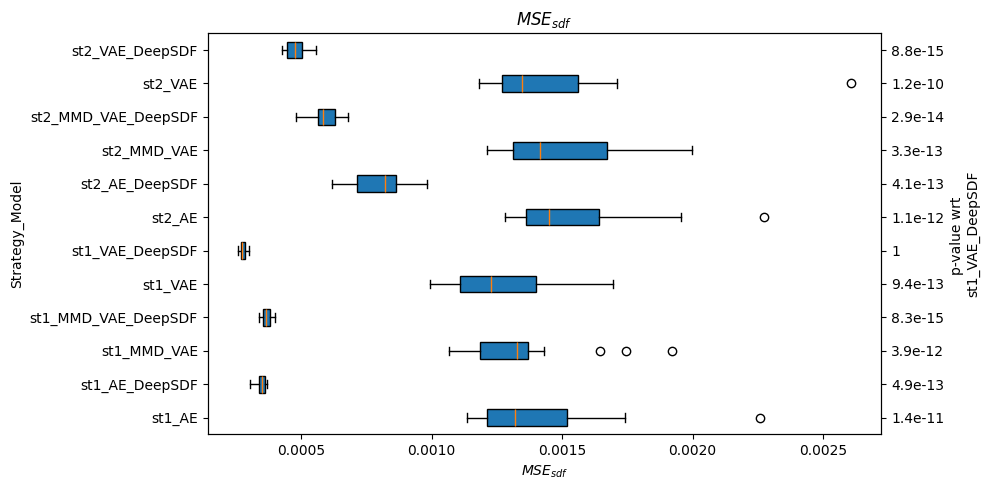

In [17]:

p_args = {"p_matrixes": p_values_matrixes,
          "wrt_models_from_metric": {
              "val_sdf_loss/dataloader_idx_0": "st1_VAE_DeepSDF",
              "val_smoothness_diff/dataloader_idx_1": "st1_VAE_DeepSDF",
              "val_reconstruction_loss": "st2_VAE"
          }}

filename = os.path.join(save_dir, "T-test_boxplot_all_model_MSE_sdf.png")

boxplot_metrics(combined_raw_metrics, model_names, [metrics_to_test[0]], latex_table_headers,
                p_args=p_args,
                filename=filename)

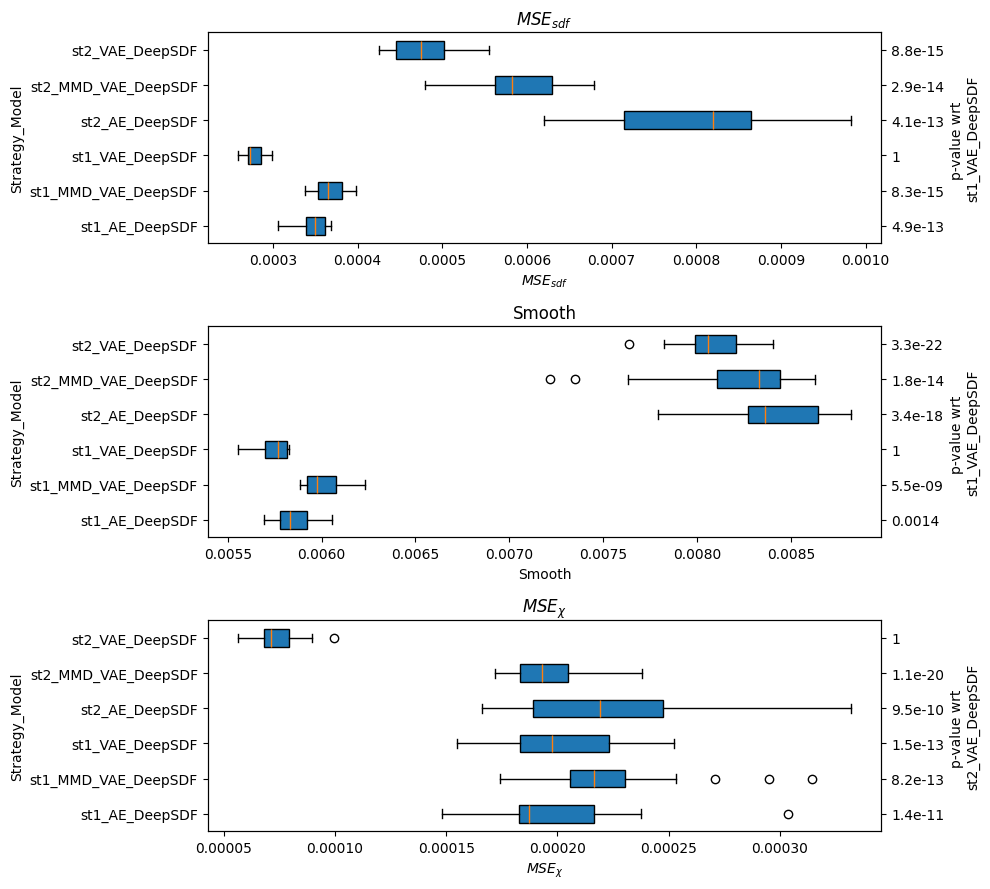

In [20]:
inclusion_list = ["DeepSDF"]

p_args = {"p_matrixes": p_values_matrixes,
          "wrt_models_from_metric": {
              "val_sdf_loss/dataloader_idx_0": "st1_VAE_DeepSDF",
              "val_smoothness_diff/dataloader_idx_1": "st1_VAE_DeepSDF",
              "val_reconstruction_loss": "st2_VAE_DeepSDF"
          }}

filename = os.path.join(save_dir, "T-test_boxplot_DeepSDF.png")


boxplot_metrics(combined_raw_metrics, model_names, metrics_to_test, latex_table_headers,
                p_args=p_args,
                inclusion_list=inclusion_list, figs_y_scale=3,
                filename=filename)



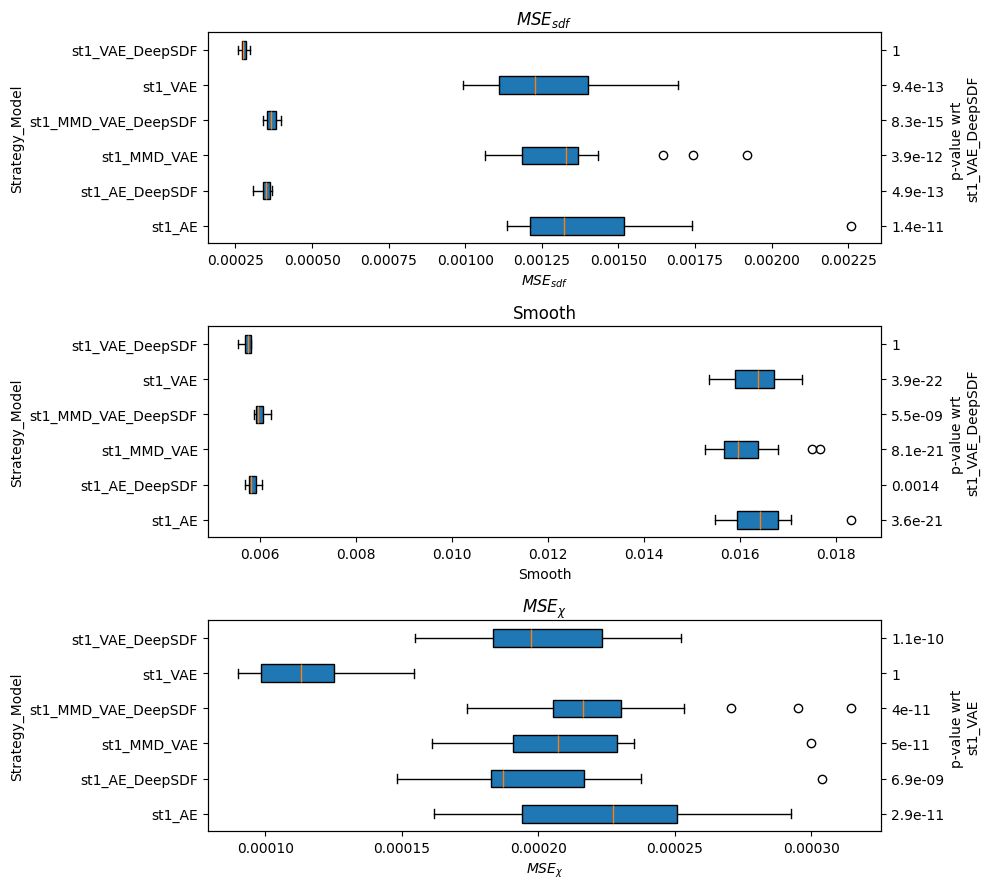

In [21]:
inclusion_list = ["st1"]

p_args = {"p_matrixes": p_values_matrixes,
          "wrt_models_from_metric": {
              "val_sdf_loss/dataloader_idx_0": "st1_VAE_DeepSDF",
              "val_smoothness_diff/dataloader_idx_1": "st1_VAE_DeepSDF",
              "val_reconstruction_loss": "st1_VAE"
          }}

filename = os.path.join(save_dir, "T-test_boxplot_st1.png")

boxplot_metrics(combined_raw_metrics, model_names, metrics_to_test, latex_table_headers,
                inclusion_list=inclusion_list, 
                p_args=p_args,
                figs_y_scale=3,
                filename=filename)

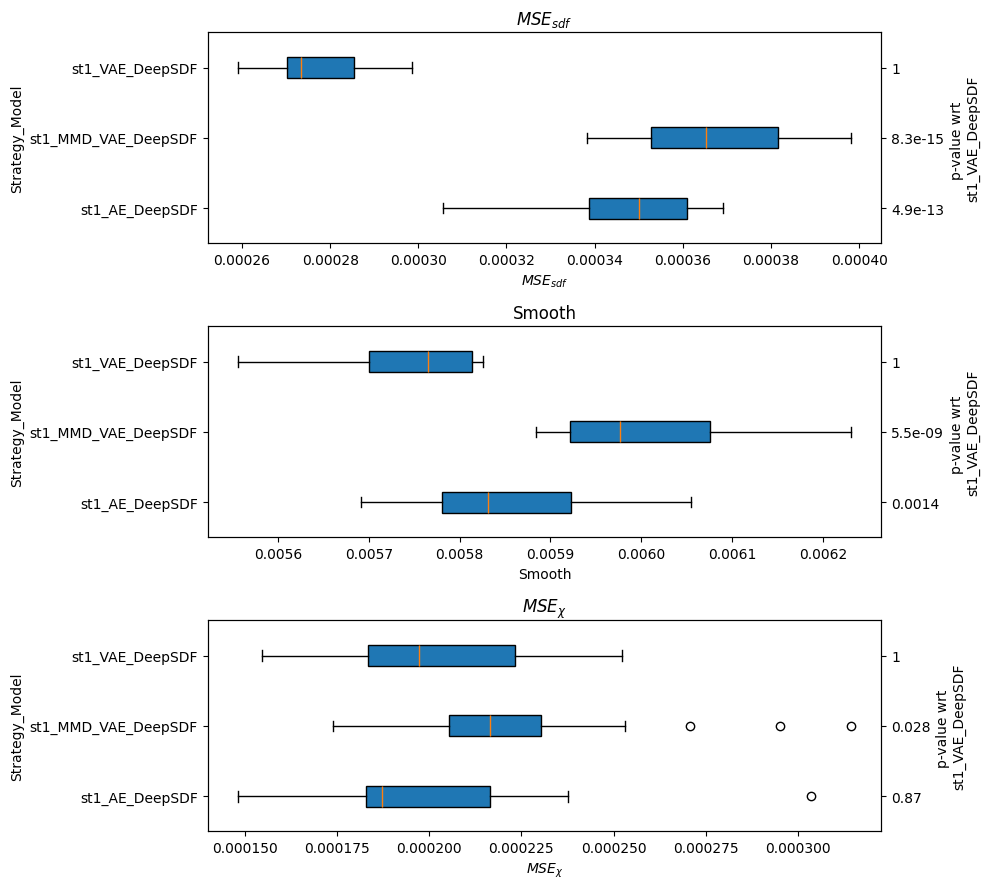

In [22]:
exclusion_list = ["st2"]
inclusion_list = ["DeepSDF"]

p_args = {"p_matrixes": p_values_matrixes,
          "wrt_models_from_metric": {
              "val_sdf_loss/dataloader_idx_0": "st1_VAE_DeepSDF",
              "val_smoothness_diff/dataloader_idx_1": "st1_VAE_DeepSDF",
              "val_reconstruction_loss":  "st1_VAE_DeepSDF"
          }}

filename = os.path.join(save_dir, "T-test_boxplot_st1_DeepSDF.png")

boxplot_metrics(combined_raw_metrics, model_names, metrics_to_test,
                latex_table_headers, exclusion_list=exclusion_list,
                inclusion_list=inclusion_list, 
                p_args=p_args,
                figs_y_scale=3,
                filename=filename)